In [384]:
from torch.utils.data import Dataset, DataLoader
from torchvision import models, utils, datasets, transforms
import torchvision
import torchvision.transforms as transforms
import numpy as np
import sys
import os
from PIL import Image
import matplotlib.pyplot as plt

In [385]:
transform_train = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821)),
])

transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821)),
])

In [386]:
class TinyImageNet(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.Train = train
        self.root_dir = root
        self.transform = transform
        self.train_dir = os.path.join(self.root_dir, "train")
        self.val_dir = os.path.join(self.root_dir, "val")

        if (self.Train):
            self._create_class_idx_dict_train()
        else:
            self._create_class_idx_dict_val()

        self._make_dataset(self.Train)

        words_file = os.path.join(self.root_dir, "words.txt")
        wnids_file = os.path.join(self.root_dir, "wnids.txt")

        self.set_nids = set()

        with open(wnids_file, 'r') as fo:
            data = fo.readlines()
            for entry in data:
                self.set_nids.add(entry.strip("\n"))

        self.class_to_label = {}
        with open(words_file, 'r') as fo:
            data = fo.readlines()
            for entry in data:
                words = entry.split("\t")
                if words[0] in self.set_nids:
                    self.class_to_label[words[0]] = (words[1].strip("\n").split(","))[0]

    def _create_class_idx_dict_train(self):
        if sys.version_info >= (3, 5):
            classes = [d.name for d in os.scandir(self.train_dir) if d.is_dir()]
        else:
            classes = [d for d in os.listdir(self.train_dir) if os.path.isdir(os.path.join(train_dir, d))]
        classes = sorted(classes)
        num_images = 0
        for root, dirs, files in os.walk(self.train_dir):
            for f in files:
                if f.endswith(".JPEG"):
                    num_images = num_images + 1

        self.len_dataset = num_images;

        self.tgt_idx_to_class = {i: classes[i] for i in range(len(classes))}
        self.class_to_tgt_idx = {classes[i]: i for i in range(len(classes))}

    def _create_class_idx_dict_val(self):
        val_image_dir = os.path.join(self.val_dir, "images")
        if sys.version_info >= (3, 5):
            images = [d.name for d in os.scandir(val_image_dir) if d.is_file()]
        else:
            images = [d for d in os.listdir(val_image_dir) if os.path.isfile(os.path.join(train_dir, d))]
        val_annotations_file = os.path.join(self.val_dir, "val_annotations.txt")
        self.val_img_to_class = {}
        set_of_classes = set()
        with open(val_annotations_file, 'r') as fo:
            entry = fo.readlines()
            for data in entry:
                words = data.split("\t")
                self.val_img_to_class[words[0]] = words[1]
                set_of_classes.add(words[1])

        self.len_dataset = len(list(self.val_img_to_class.keys()))
        classes = sorted(list(set_of_classes))
        # self.idx_to_class = {i:self.val_img_to_class[images[i]] for i in range(len(images))}
        self.class_to_tgt_idx = {classes[i]: i for i in range(len(classes))}
        self.tgt_idx_to_class = {i: classes[i] for i in range(len(classes))}

    def _make_dataset(self, Train=True):
        self.images = []
        if Train:
            img_root_dir = self.train_dir
            list_of_dirs = [target for target in self.class_to_tgt_idx.keys()]
        else:
            img_root_dir = self.val_dir
            list_of_dirs = ["images"]

        for tgt in list_of_dirs:
            dirs = os.path.join(img_root_dir, tgt)
            if not os.path.isdir(dirs):
                continue

            for root, _, files in sorted(os.walk(dirs)):
                for fname in sorted(files):
                    if (fname.endswith(".JPEG")):
                        path = os.path.join(root, fname)
                        if Train:
                            item = (path, self.class_to_tgt_idx[tgt])
                        else:
                            item = (path, self.class_to_tgt_idx[self.val_img_to_class[fname]])
                        self.images.append(item)

    def return_label(self, idx):
        return [self.class_to_label[self.tgt_idx_to_class[i.item()]] for i in idx]

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, idx):
        img_path, tgt = self.images[idx]
        with open(img_path, 'rb') as f:
            sample = Image.open(img_path)
            sample = sample.convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)

        return sample, tgt

In [387]:
data_dir = './data/tiny-imagenet-200/'
dataset_train = TinyImageNet(data_dir, train=True)
dataset_val = TinyImageNet(data_dir, train=False)

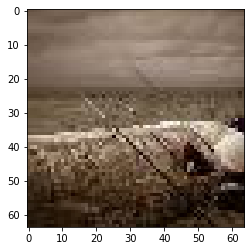

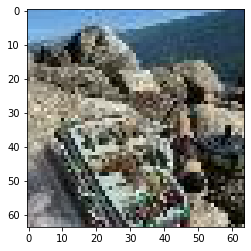

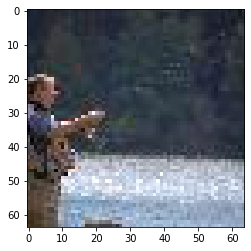

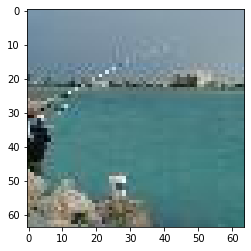

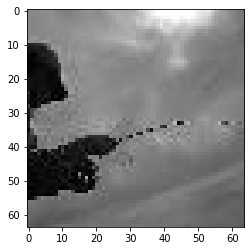

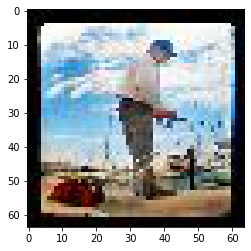

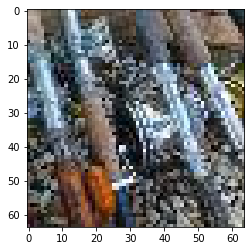

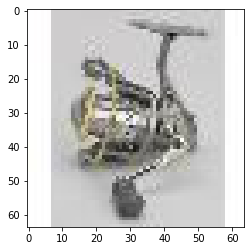

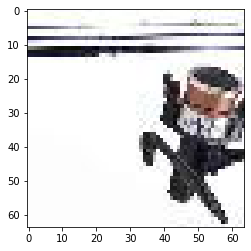

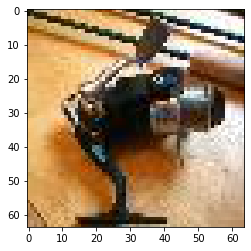

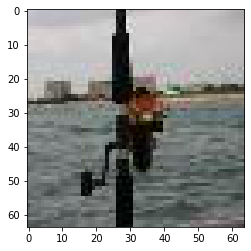

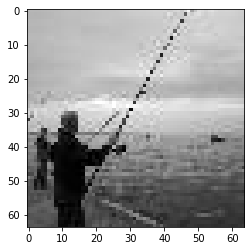

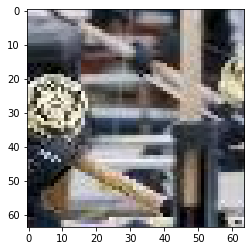

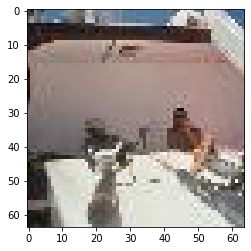

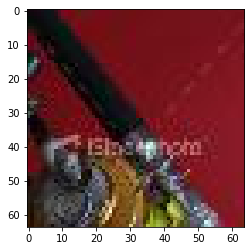

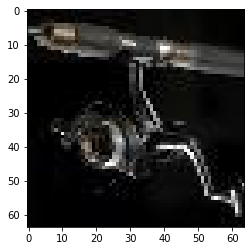

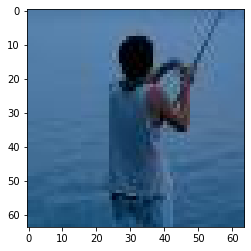

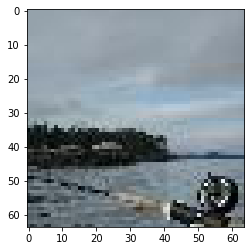

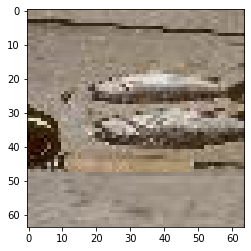

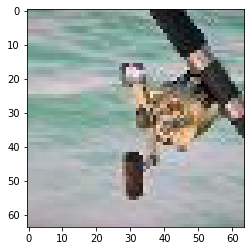

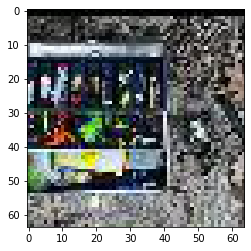

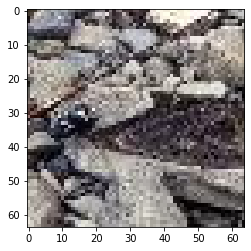

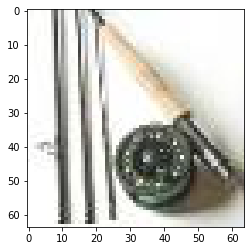

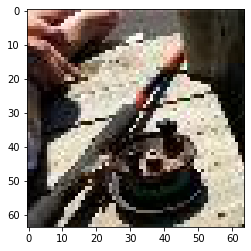

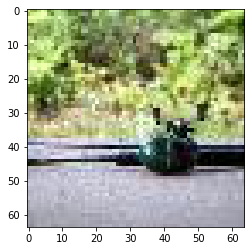

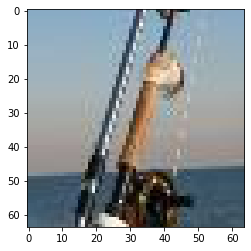

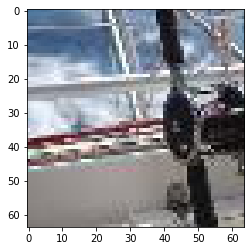

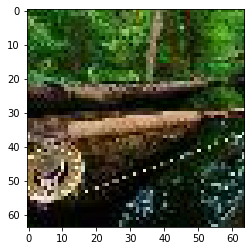

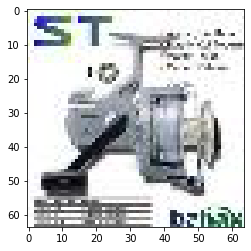

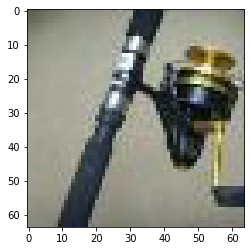

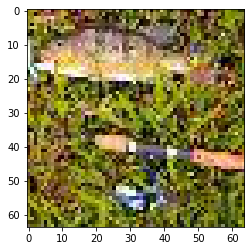

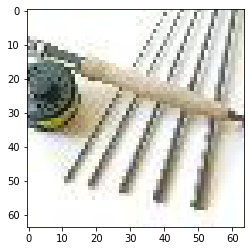

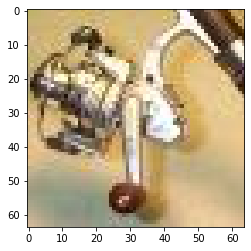

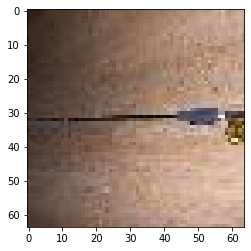

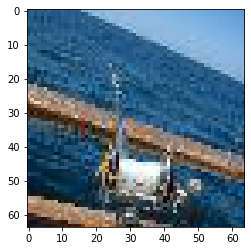

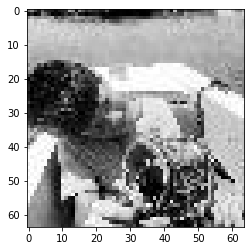

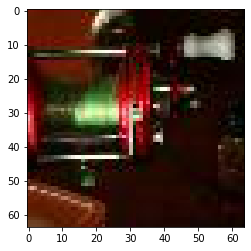

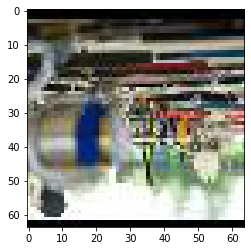

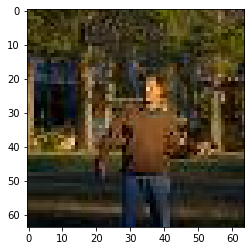

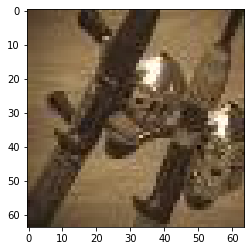

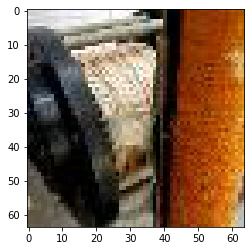

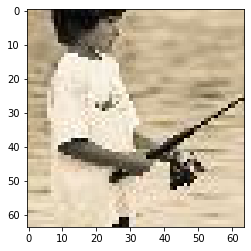

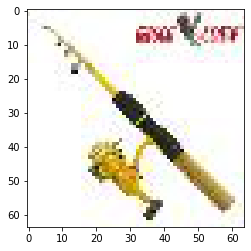

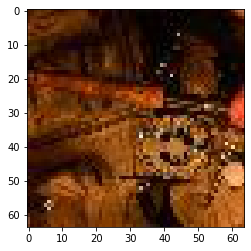

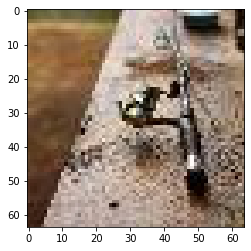

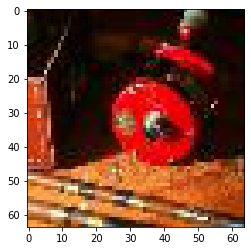

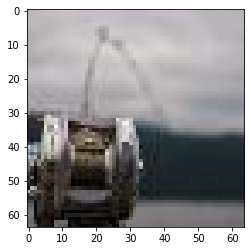

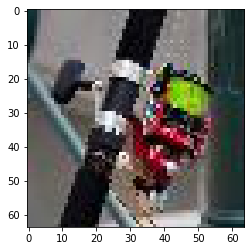

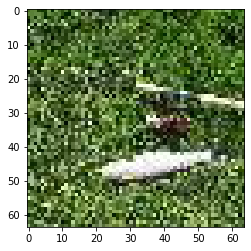

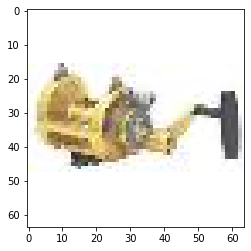

In [388]:
counter = 0
for i in range(100000):
    if counter == 50:
        break
    img,label = dataset_val[i]
    if label == 139:
        plt.imshow(img)
        plt.show()
        counter+= 1

In [389]:
# counter = 0
# for i in range(100000):
#     if counter == 10:
#         break
#     img,label = dataset_train[i]
#     if label == 139:
#         plt.imshow(img)
#         plt.show()
#         counter+= 1

In [390]:
import os
import sys
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
from torchvision import transforms

In [391]:
data_dir = './data/tiny-imagenet-200/'

In [392]:
labels_t = []
image_names = []
with open(data_dir+'wnids.txt') as wnid:
    for line in wnid:
        labels_t.append(line.strip('\n'))
for label in labels_t:
    txt_path = data_dir+'train/'+label+'/'+label+'_boxes.txt'
    image_name = []
    with open(txt_path) as txt:
        for line in txt:
            image_name.append(line.strip('\n').split('\t')[0])
    image_names.append(image_name)
labels = np.arange(200)

In [393]:
val_labels_t = []
val_labels = []
val_names = []
with open(data_dir+'val/val_annotations.txt') as txt:
    for line in txt:
        val_names.append(line.strip('\n').split('\t')[0])
        val_labels_t.append(line.strip('\n').split('\t')[1])
for i in range(len(val_labels_t)):
    for i_t in range(len(labels_t)):
        if val_labels_t[i] == labels_t[i_t]:
            val_labels.append(i_t)
val_labels = np.array(val_labels)

In [394]:
class data(Dataset):
    def __init__(self, type, transform=None):
        self.type = type
        if type == 'train':
            i = 0
            self.images = []
            for label in labels_t:
                image = []
                for image_name in image_names[i]:
                    image_path = os.path.join(data_dir+'/train', label, 'images', image_name) 
                    image.append(cv2.imread(image_path))
                self.images.append(image)
                i = i + 1
            self.images = np.array(self.images)
            self.images = self.images.reshape(-1, 64, 64, 3)
        elif type == 'val':
            self.val_images = []
            for val_image in val_names:
                val_image_path = os.path.join(data_dir+'/val/images', val_image)
                self.val_images.append(cv2.imread(val_image_path))
            self.val_images = np.array(self.val_images)
        self.transform = transform
        
    def __getitem__(self, index):
        label = []
        image = []
        if self.type == 'train':
            label = index//500
            image = self.images[index]
        if self.type == 'val':
            label = val_labels[index]
            image = self.val_images[index]
        if self.transform is not None:
            image = self.transform(image)
        return label, image
        
    def __len__(self):
        len = 0
        if self.type == 'train':
            len = self.images.shape[0]
        if self.type == 'val':
            len = self.val_images.shape[0]
        return len

In [395]:
dataset_train = data( 'train')
dataset_val = data('val')

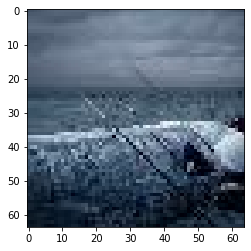

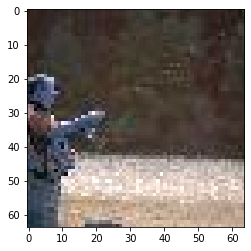

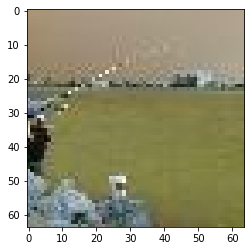

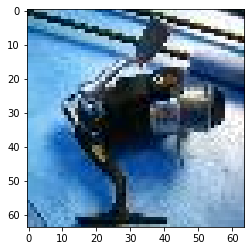

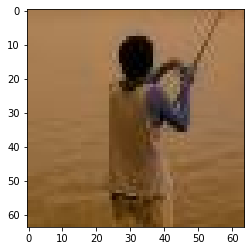

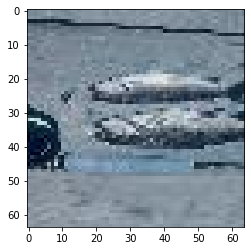

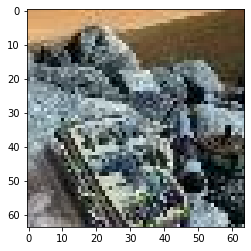

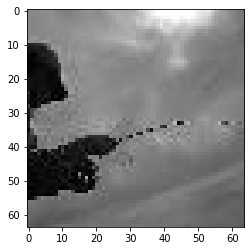

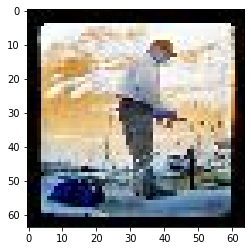

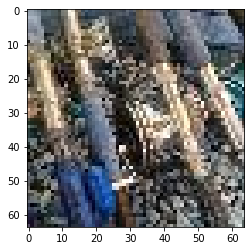

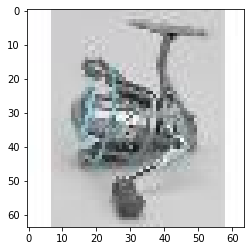

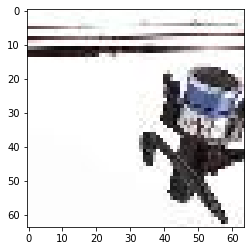

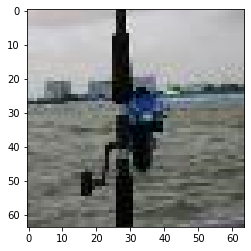

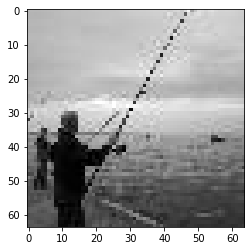

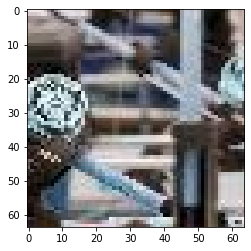

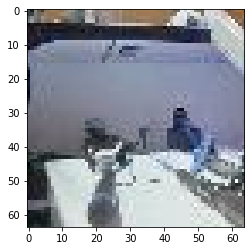

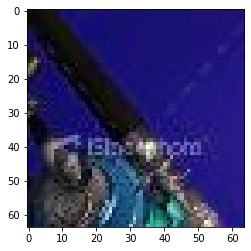

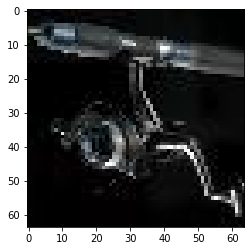

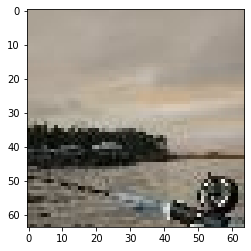

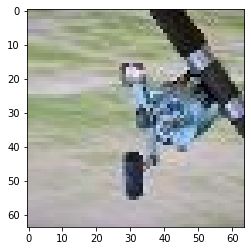

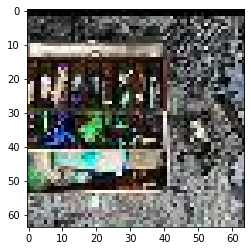

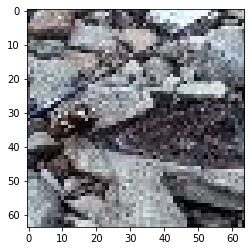

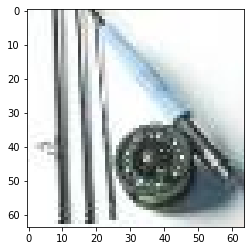

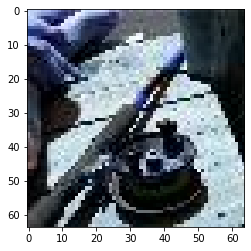

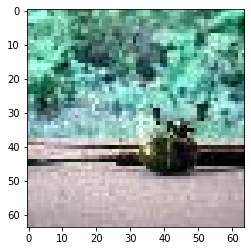

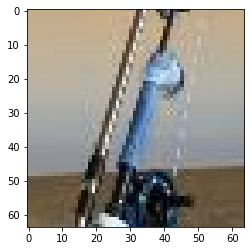

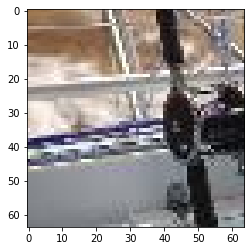

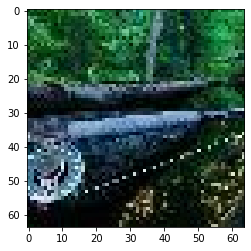

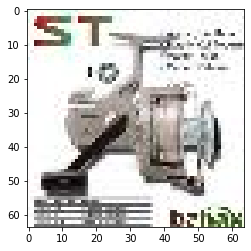

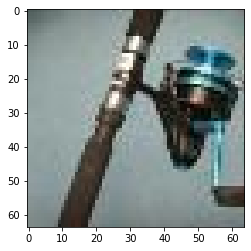

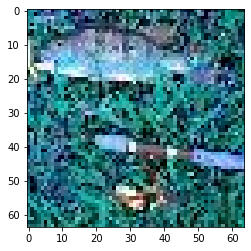

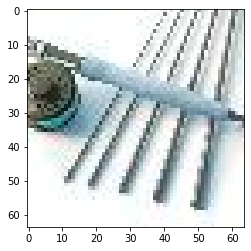

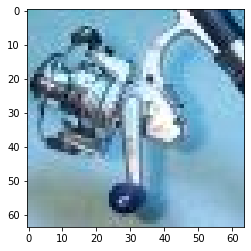

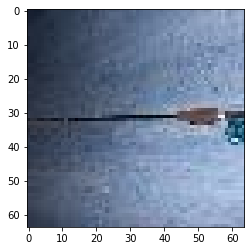

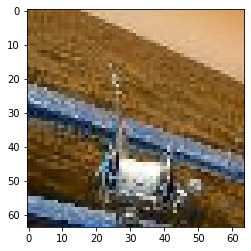

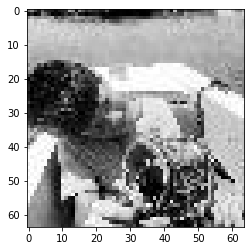

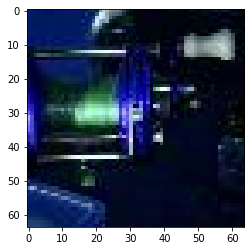

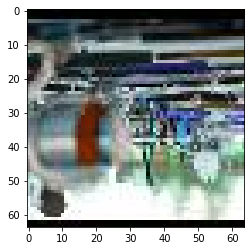

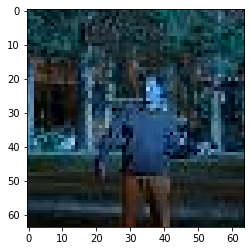

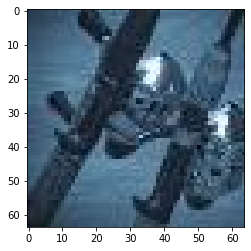

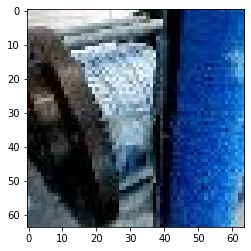

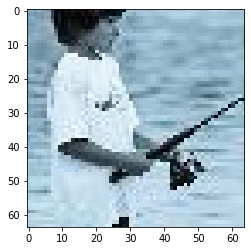

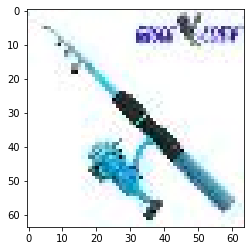

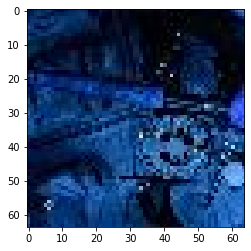

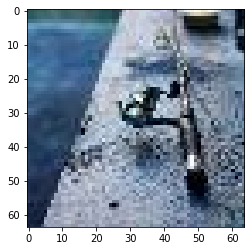

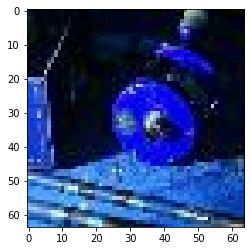

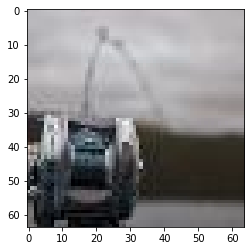

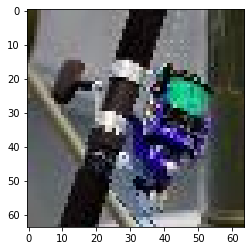

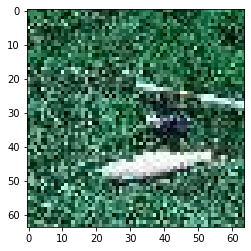

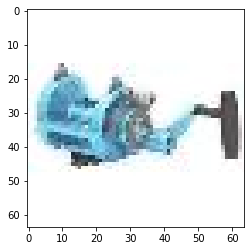

In [396]:
counter = 0
for i in range(10000):
    if counter == 50:
        break
    label,img = dataset_val[i]

    if label == 1:
        plt.imshow(img)
        plt.show()
#         print(counter)
        counter+= 1

In [397]:
# counter = 0
# for i in range(100000):
#     if counter == 10:
#         break
#     label,img = dataset_train[i]
#     if label == 1:
#         plt.imshow(img)
#         plt.show()
#         counter+= 1